<H1> Introduction to scPrisma- De novo reconstruction </h1>
<h1>Analysis of the cell cycle in HeLa S3 cells</h1>

This tutorial aims to provide a comprehensive overview of the scPrisma workflow, including the following steps:

1. Reconstruction of a target signal from scratch, utilizing only topological prior information.
3. Identification of genes related to the target signal, including the adjustment of regularization parameter.
4. Amplification of the desired signal, including the adjustment of regularization parameter.
5. Filtering of the desired signal, including the adjustment of regularization parameter.
The example used in this tutorial is based on HeLa S3 cells from <a href="https://doi.org/10.15252/msb.20209946">Schwabe, Daniel, et al. Molecular systems biology(2020)
</a>. 
<br />
The data can be download from <a href="https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4224315" >here</a>.



In [1]:
#######imports and data read#######
import copy
import time
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import scPrisma
import h5py
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
adata = sc.read_csv('./GSM4224315_out_gene_exon_tagged.dge_exonssf002_WT.txt', delimiter='\t').T

<h2>Standard pre-processing</h2> <br />
Using a standard RNA-seq pre-processing pipeline involving normalization of counts per cell, log(1+x) over the entire data and selection of highly variable genes is highly recommended. 

Gene selection is mandatory when trying to reconstruct a cyclic signal de novo (without prior knowledge).

Scaling the genes to zero mean and variance of one is not mandatory.



In [2]:
sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
orig_adata  = adata.copy()
sc.pp.filter_genes_dispersion(adata,n_top_genes=7000)

Note: it is possible

<h3>De novo- reconstruction</h3>

In [3]:
E_sga  , E_rec_sga = scPrisma.algorithms_torch.reconstruction_cyclic_torch(adata.X , iterNum=100)


Iteration number: 
0
Iteration number: 
25
Iteration number: 
50
Iteration number: 
75
torch.cuda.memory_allocated: 0.043618GB


In [4]:
sga_range= scPrisma.algorithms_torch.e_to_range(E_rec_sga)
adata = adata[sga_range,:]
orig_adata = copy.deepcopy(adata.copy())

We will validate that the reconstruction algorithm indeed converged to the cell cycle signal we will use 3 different phase marker genes. All of the peaktime were taken from <a href="https://cyclebase.org/">Cyclebase</a>. <br />
"CCNE2"- Peaktime at 'S' phase.<br />
"CDK1"- Peaktime at 'G2' phase.<br />
"CDC20"- Peaktime at 'M' phase.

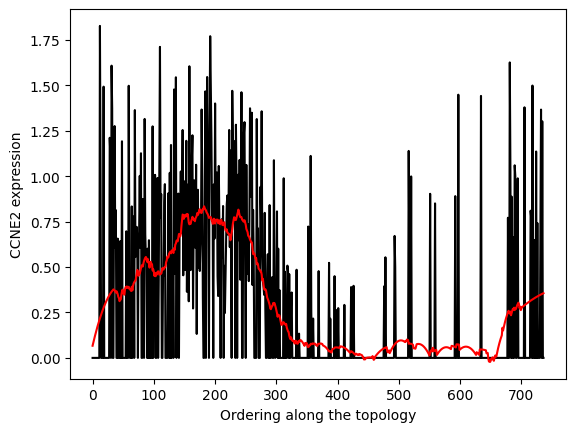

In [5]:
plt.plot(adata[:,"CCNE2"].X[:,0],color='black') #Peaktime at S
plt.plot(savgol_filter(adata[:,"CCNE2"].X[:,0],70,2), color='r')

plt.ylabel('CCNE2 expression')
plt.xlabel('Ordering along the topology')
plt.show()

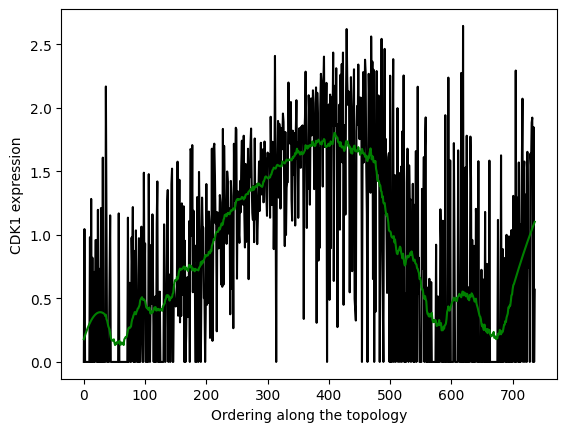

In [6]:
plt.plot(adata[:,"CDK1"].X[:,0],color='black') #Peaktime at G2
plt.plot(savgol_filter(adata[:,"CDK1"].X[:,0],70,2), color='g')

plt.ylabel('CDK1 expression')
plt.xlabel('Ordering along the topology')
plt.show()

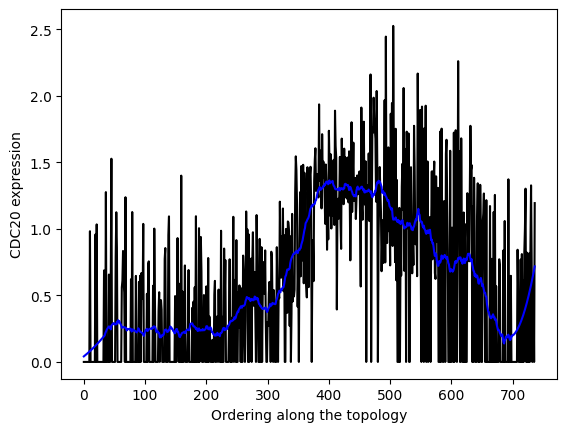

In [7]:
plt.plot(adata[:,"CDC20"].X[:,0],color='black') #Peaktime at M
plt.plot(savgol_filter(adata[:,"CDC20"].X[:,0],70,2), color='b')

plt.ylabel('CDC20 expression')
plt.xlabel('Ordering along the topology')
plt.show()

<h2> B- Enhancement workflow</h2>
<h3> B.1 Genes inference</h3>
Having obtained the reconstructed signal, either through the reconstruction problem or from prior knowledge, it is necessary to identify the informative genes that are related to the desired signal.

Due to convexity considerations, it would be easier to infer genes that are not related to the desired signal, and then flip the results. 

Regularization is the only parameter important to choose. By keeping a large value, the "filter_cyclic_genes" algorithm would keep more cyclic genes, which would then be filtered later by flipping.

It can be optimized manually (as shown in XXXX) or automatically (XXX). In this case, we will choose a value that maintains a large number of genes, filter out a large number of genes, and validate that a 'flat' gene ("AASDHPPT", as defined by "Cycle base") is removed and a smooth gene ("CDC20") is kept.

For example: Using regularizaiton of 0 will cause that all the genes would be kept.

Iteration number: 
1
Iteration number: 
26
Iteration number: 
51
Iteration number: 
76
torch.cuda.memory_allocated: 0.408443GB


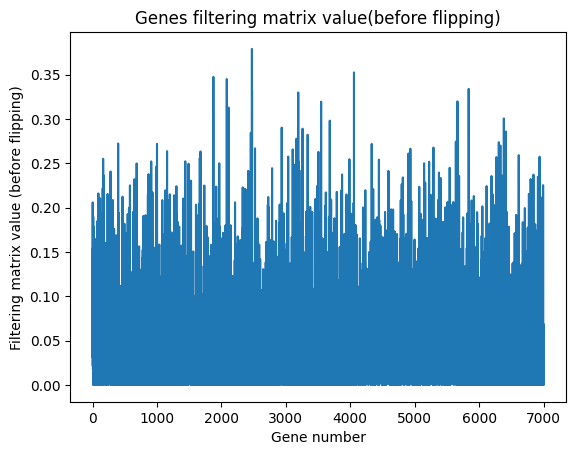

In [8]:
D = scPrisma.algorithms_torch.filter_cyclic_genes_torch(adata.X,regu=0, iterNum=100)
plt.plot(D.diagonal())
plt.xlabel("Gene number")
plt.ylabel("Filtering matrix value (before flipping)")
plt.title("Genes filtering matrix value(before flipping)")
plt.show()

For example: Using regularizaiton of 1 will cause that most of the genes to be filtered out.

Iteration number: 
1
Iteration number: 
26
Iteration number: 
51
Iteration number: 
76
torch.cuda.memory_allocated: 0.408443GB


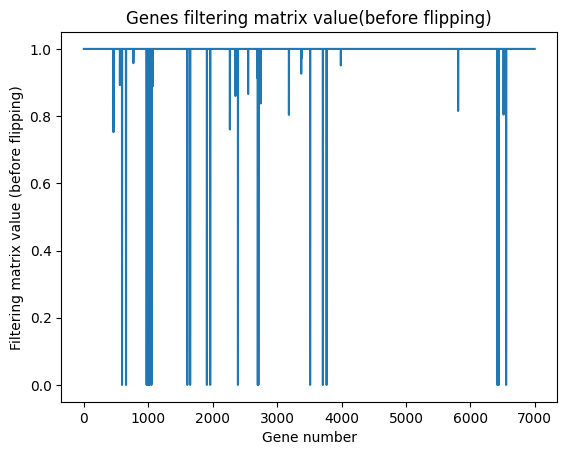

In [9]:
D = scPrisma.algorithms_torch.filter_cyclic_genes_torch(adata.X,regu=1, iterNum=100)
plt.plot(D.diagonal())
plt.xlabel("Gene number")
plt.ylabel("Filtering matrix value (before flipping)")
plt.title("Genes filtering matrix value(before flipping)")
plt.show()

For example: Using regularizaiton of 0.2 indeed keep a large amount of genes and filter ut lage amount of genes.

Iteration number: 
1
Iteration number: 
26
Iteration number: 
51
Iteration number: 
76
torch.cuda.memory_allocated: 0.408443GB


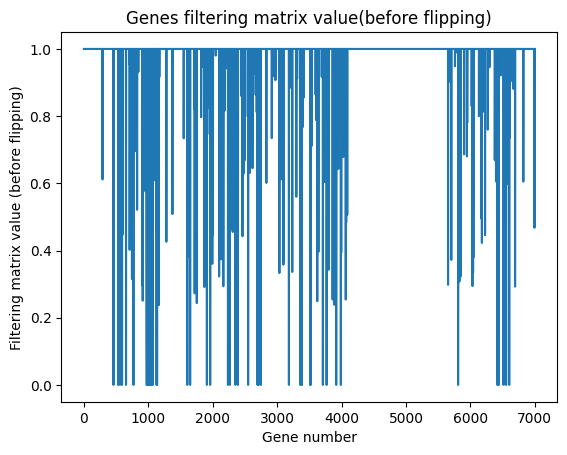

In [10]:
D = scPrisma.algorithms_torch.filter_cyclic_genes_torch(adata.X,regu=0.2, iterNum=100)
plt.plot(D.diagonal())
plt.xlabel("Gene number")
plt.ylabel("Filtering matrix value (before flipping)")
plt.title("Genes filtering matrix value(before flipping)")
plt.show()

Remember to flip before applying the filtering.

In [11]:
D_flipped = np.identity(D.shape[0])-D
adata_enhancement = adata.copy()
adata_enhancement.X = adata_enhancement.X.dot(D_flipped)

We can see that 'CDC20' was not filtered out, while "AASDHPPT" was filtered out.

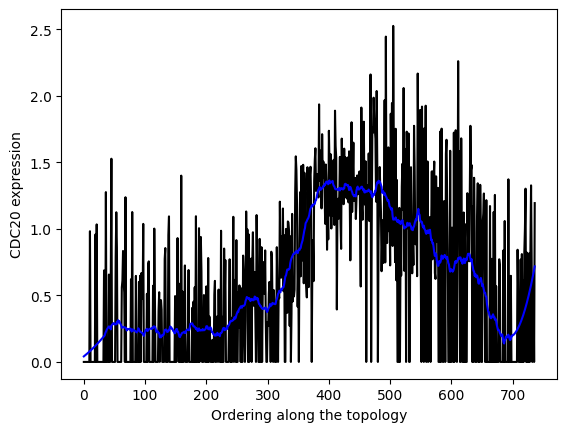

In [12]:
plt.plot(adata_enhancement[:,"CDC20"].X[:,0],color='black') #Peaktime at M
plt.plot(savgol_filter(adata_enhancement[:,"CDC20"].X[:,0],70,2), color='b')

plt.ylabel('CDC20 expression')
plt.xlabel('Ordering along the topology')
plt.show()

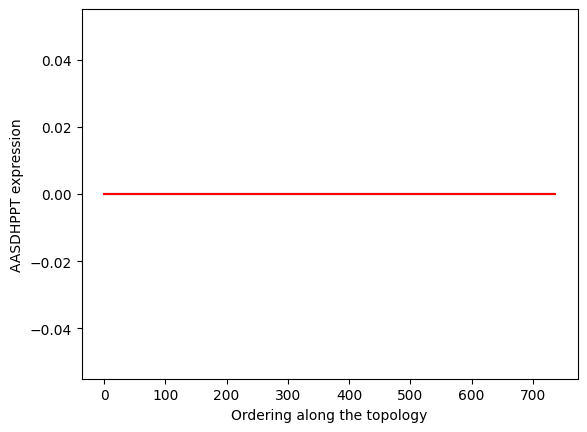

In [13]:
plt.plot(adata_enhancement[:,"AASDHPPT"].X[:,0],color='black') #Peaktime at M
plt.plot(savgol_filter(adata_enhancement[:,"AASDHPPT"].X[:,0],70,2), color='r')

plt.ylabel('AASDHPPT expression')
plt.xlabel('Ordering along the topology')
plt.show()

<h3> B.2 Cyclic enhancement</h3>
Having only the genes which are smooth over the inferred topology. We will clear from them the expression profiles which are not related to the cell cycle.

Here we also need to tune the regularization parameter. Higher regularization would lead to filter out more expression profiles which are not related to the reconstructed signal. <br />
It can also be validated using marker genes (such as 'CDC20'). We highly recommend using as little regularization as possible to avoid overfitting.
We can also take a look at the filtering matrix and see that it is not zeros matrix.

0
cuda
starting filtering
Iteration number: 1
torch.cuda.memory_allocated: 0.101704GB


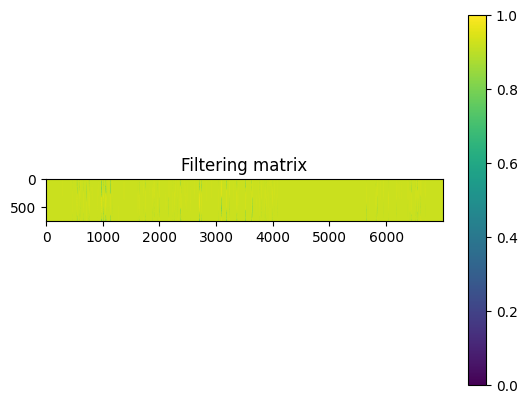

In [14]:
F = scPrisma.algorithms_torch.enhancement_cyclic_torch(adata_enhancement.X,regu=0.01,iterNum=100)

plt.imshow(F)
plt.title("Filtering matrix")
plt.colorbar()
plt.show()

In [15]:
adata_enhancement.X = adata_enhancement.X * F

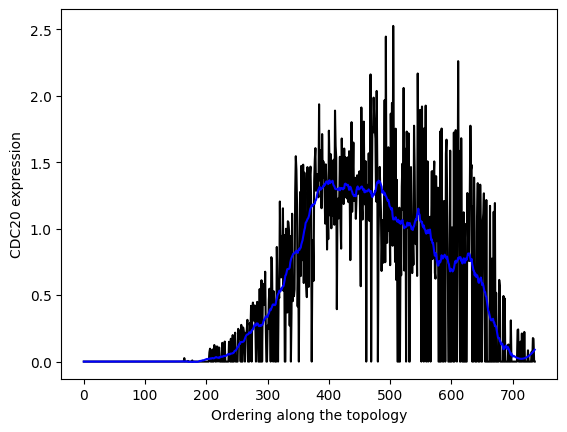

In [16]:
plt.plot(adata_enhancement[:,"CDC20"].X[:,0],color='black') #Peaktime at M
plt.plot(savgol_filter(adata_enhancement[:,"CDC20"].X[:,0],70,2), color='b')

plt.ylabel('CDC20 expression')
plt.xlabel('Ordering along the topology')
plt.show()

<h3>C.Signal Filtering</h3>
If insead of enhancing the reconstructed signal, we want to filter it out we can use cyclic filtering algorithm.

Here, we also have a regularization parameter, higher regularization would lead to less removal of expression profiles which are related to the reconstructed signal

In [17]:
adata_filtered = copy.deepcopy(adata.copy())
F = scPrisma.algorithms_torch.filtering_cyclic_torch(adata_filtered.X,regu=0,iterNum=300 , line_search=True)


0
cuda
starting filtering
25
th Iteration    Loss :: 
tensor(73.0016, device='cuda:0', dtype=torch.float64)
50
th Iteration    Loss :: 
tensor(45.3004, device='cuda:0', dtype=torch.float64)
75
th Iteration    Loss :: 
tensor(32.4346, device='cuda:0', dtype=torch.float64)
100
th Iteration    Loss :: 
tensor(24.9907, device='cuda:0', dtype=torch.float64)
125
th Iteration    Loss :: 
tensor(20.1856, device='cuda:0', dtype=torch.float64)
150
th Iteration    Loss :: 
tensor(16.8591, device='cuda:0', dtype=torch.float64)
175
th Iteration    Loss :: 
tensor(14.4351, device='cuda:0', dtype=torch.float64)
200
th Iteration    Loss :: 
tensor(12.6001, device='cuda:0', dtype=torch.float64)
225
th Iteration    Loss :: 
tensor(11.1671, device='cuda:0', dtype=torch.float64)
250
th Iteration    Loss :: 
tensor(10.0227, device='cuda:0', dtype=torch.float64)
275
th Iteration    Loss :: 
tensor(9.0901, device='cuda:0', dtype=torch.float64)
300
th Iteration    Loss :: 
tensor(8.3172, device='cuda:0', dtyp

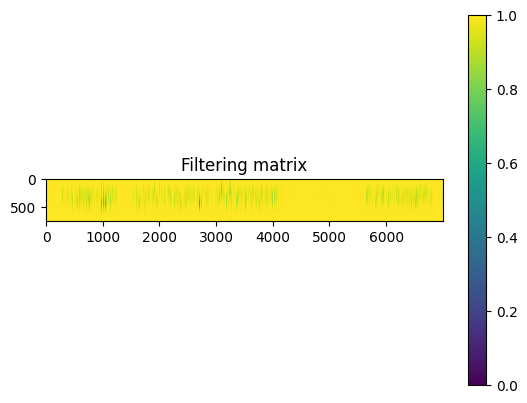

In [18]:
plt.imshow(F)
plt.title("Filtering matrix")
plt.colorbar()
plt.show()

In [19]:
adata_filtered.X = adata_filtered.X * F


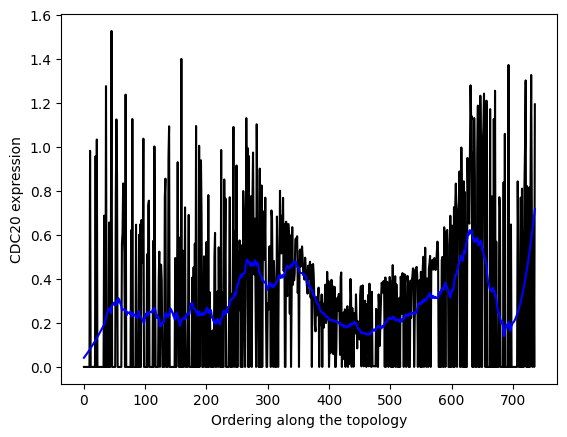

In [20]:
plt.plot(adata_filtered[:,"CDC20"].X[:,0],color='black') #Peaktime at M
plt.plot(savgol_filter(adata_filtered[:,"CDC20"].X[:,0],70,2), color='b')

plt.ylabel('CDC20 expression')
plt.xlabel('Ordering along the topology')
plt.show()